In [1]:
import os
import csv 
import sys 
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import util

c:\python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def extract_feats(ffs, direc="train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.

    returns: 
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order 
      of their rows in the design matrix.
      
      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = [] 
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        fds.append(rowfd)
    
    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids

In [3]:
def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.
       
    returns: 
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds 
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(fd.keys()) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict
    
    cols = []
    rows = []
    data = []        
    for i in xrange(len(fds)):
        temp_cols = []
        temp_data = []
        for feat,val in fds[i].iteritems():
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)
   

    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict

In [4]:
def system_call_4_grams_feats(tree):
    c = Counter()
    in_all_section = False
    first = False # is this the first system call
    first_call = ""
    second = False
    second_call = ""
    third = False
    third_call = ""
    call_counter = 0
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
            first = True
            second = False
            third = False
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
            first = False
            second = False
            third = False
        elif in_all_section:
            call_counter += 1
            if first:
                first_call = el.tag
                first = False
                second = True
                third = False
            elif second:
                second_call = el.tag
                second = False
                third = False
            elif third:
                third_call = el.tag
                third = False
            else:
                c[first_call+'-'+second_call+'-'+third_call+'-'+el.tag] += 1
                first_call = second_call
                second_call = third_call
                third_call = el.tag
                
    for k, v in c.items():
        c[k] = v / float(call_counter)
    c['num_system_calls'] = call_counter
    return c

In [42]:
def system_call_2_grams_feats(tree):
    c = Counter()
    in_all_section = False
    first = False # is this the first system call
    first_call = ""
    call_counter = 0
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
            first = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
            first = False
        elif in_all_section:
            call_counter += 1
            if first:
                if el.tag == "load_dll" and "filename_hash" in el.attrib:
                    first_call = el.attrib["filename_hash"]
                else:
                    first_call = el.tag
                first = False
            else:
                sys_call = ""
                if el.tag == "load_dll" and "filename_hash" in el.attrib:
                    sys_call = el.attrib["filename_hash"]
                else:
                    sys_call = el.tag
                c[first_call+'-'+sys_call] += 1
                first_call = sys_call
                
    for k, v in c.items():
        c[k] = v / float(call_counter)
    c['num_system_calls'] = call_counter
    return c

In [5]:
def reorder_submission(file_to_reorder, newfile_name = "experiment_results.csv"):
    # READ IN KEYS IN CORRECT ORDER AS LIST
    with open('keys.csv','r') as f:
        keyreader = csv.reader(f)
        keys = [key[0] for key in keyreader]

    # READ IN ALL PREDICTIONS, REGARDLESS OF ORDER
    with open(file_to_reorder) as f:
        oldfile_reader = csv.reader(f)
        D = {}
        for i,row in enumerate(oldfile_reader):
            if i == 0:
                continue
            _id, pred = row 
            D[_id] = pred

    # WRITE PREDICTIONS IN NEW ORDER
    with open(newfile_name,'wb') as f:
        writer = csv.writer(f)
        writer.writerow(('Id','Prediction'))
        for key in keys:
            writer.writerow((key,D[key]))

    print("".join(["Reordered ", file_to_reorder," and wrote to ", newfile_name]))

In [6]:
#############################
#
#  Below is main function
#
#############################

In [7]:
train_dir = "../train/sub_train"
test_dir = "../train/sub_test"
submission_dir = "../test"
outputfile = "experiment_predictions.csv"  # feel free to change this or take it as an argument
ffs = [system_call_4_grams_feats] # TODO put the names of the feature functions you've defined above in this list

In [8]:
# extract features
print "extracting training features..."
X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)

y_train = np.zeros((len(t_train),len(util.malware_classes)))
y_train[np.arange(len(t_train)), t_train] = 1

extracting training features...


In [9]:
print "extracting test features..."
X_test,_,t_test,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)

y_test = np.zeros((len(t_test),len(util.malware_classes)))
y_test[np.arange(len(t_test)), t_test] = 1

# print y_train.shape
# print y_test.shape

extracting test features...


In [46]:
print "extracting submission features..."
X_submission,_,t_submission,submission_ids = extract_feats(ffs, submission_dir, global_feat_dict=global_feat_dict)

extracting submission features...


In [40]:
train, test = [], []
for i in range(10, 21, 1):
    train.append([])
    test.append([])
    for j in range(10, 21, 1):
        RF = RandomForestClassifier(class_weight="balanced", n_jobs=-1, max_depth=i, n_estimators=j)
        RF.fit(X_train, y_train)
        train_score, test_score = RF.score(X_train, y_train), RF.score(X_test, y_test)
        train[-1].append(train_score)
        test[-1].append(test_score)
        print 'max_depth: ', i, ', n_estimators: ', j
        print 'train: ', train_score, ', test: ', test_score
        

max_depth:  10 , n_estimators:  10
train:  0.6355591311343524 , test:  0.625
max_depth:  10 , n_estimators:  11
train:  0.6399839098954143 , test:  0.64
max_depth:  10 , n_estimators:  12
train:  0.6259050683829445 , test:  0.63
max_depth:  10 , n_estimators:  13
train:  0.2614641995172969 , test:  0.31666666666666665
max_depth:  10 , n_estimators:  14
train:  0.6411906677393403 , test:  0.6366666666666667
max_depth:  10 , n_estimators:  15
train:  0.32864038616251007 , test:  0.36
max_depth:  10 , n_estimators:  16
train:  0.5929203539823009 , test:  0.5816666666666667
max_depth:  10 , n_estimators:  17
train:  0.6206757843925985 , test:  0.63
max_depth:  10 , n_estimators:  18
train:  0.5563153660498793 , test:  0.585
max_depth:  10 , n_estimators:  19
train:  0.32220434432823813 , test:  0.3416666666666667
max_depth:  10 , n_estimators:  20
train:  0.5736122284794851 , test:  0.5716666666666667
max_depth:  11 , n_estimators:  10
train:  0.6307320997586484 , test:  0.6316666666666667

max_depth:  19 , n_estimators:  10
train:  0.7357200321802092 , test:  0.6916666666666667
max_depth:  19 , n_estimators:  11
train:  0.7079646017699115 , test:  0.6833333333333333
max_depth:  19 , n_estimators:  12
train:  0.7518101367658889 , test:  0.6966666666666667
max_depth:  19 , n_estimators:  13
train:  0.7582461786001609 , test:  0.7066666666666667
max_depth:  19 , n_estimators:  14
train:  0.7316975060337892 , test:  0.7033333333333334
max_depth:  19 , n_estimators:  15
train:  0.7240547063555913 , test:  0.68
max_depth:  19 , n_estimators:  16
train:  0.7091713596138375 , test:  0.6783333333333333
max_depth:  19 , n_estimators:  17
train:  0.7586484312148029 , test:  0.6983333333333334
max_depth:  19 , n_estimators:  18
train:  0.7578439259855189 , test:  0.7033333333333334
max_depth:  19 , n_estimators:  19
train:  0.7349155269509252 , test:  0.6983333333333334
max_depth:  19 , n_estimators:  20
train:  0.7284794851166533 , test:  0.6983333333333334
max_depth:  20 , n_estim

In [30]:
print len(train), len(train[0])
print test

10 10
[[0.3283333333333333, 0.6366666666666667, 0.6133333333333333, 0.6183333333333333, 0.62, 0.6183333333333333, 0.625, 0.6183333333333333, 0.6233333333333333, 0.6266666666666667], [0.6833333333333333, 0.67, 0.6766666666666666, 0.6766666666666666, 0.67, 0.6766666666666666, 0.67, 0.67, 0.6766666666666666, 0.6766666666666666], [0.7083333333333334, 0.6833333333333333, 0.6816666666666666, 0.6933333333333334, 0.6933333333333334, 0.6883333333333334, 0.6883333333333334, 0.695, 0.6816666666666666, 0.6883333333333334], [0.78, 0.7216666666666667, 0.7266666666666667, 0.7266666666666667, 0.7316666666666667, 0.7266666666666667, 0.725, 0.73, 0.7283333333333334, 0.7283333333333334], [0.775, 0.775, 0.785, 0.7866666666666666, 0.7883333333333333, 0.7916666666666666, 0.79, 0.7916666666666666, 0.7916666666666666, 0.795], [0.805, 0.8066666666666666, 0.8133333333333334, 0.81, 0.8133333333333334, 0.8116666666666666, 0.8116666666666666, 0.81, 0.8133333333333334, 0.8116666666666666], [0.8116666666666666, 0.82

In [47]:
RF = RandomForestClassifier(class_weight="balanced", n_jobs=-1, max_depth=50, n_estimators=10)
# print np.mean(cross_val_score(RF, X_train, y_train, cv=5))
RF.fit(X_train, y_train)
# print RF.n_features_
# print RF.feature_importances_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [48]:
preds = RF.predict(X_submission)
# print preds[0]

In [49]:
# TODO make predictions on text data and write them out
print "making predictions..."
results = np.argmax(preds, axis=1)

print "writing predictions..."
util.write_predictions(results, submission_ids, outputfile)

reorder_submission(outputfile, "Bigrams_randomforest_results.csv")

making predictions...
writing predictions...
Reordered experiment_predictions.csv and wrote to Bigrams_randomforest_results.csv


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

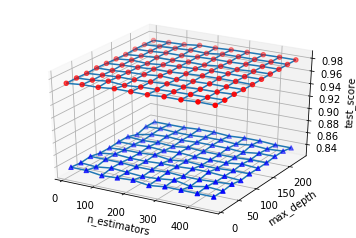

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

dim = 10
xs = np.array([[50 * i + 10] * dim for i in range(dim)])
ys = np.array([[25 * i + 10 for i in range(dim)] for _ in range(dim)])
# train = np.array([np.random.rand(dim) + 1 for _ in range(dim)])
# test = np.array([np.random.rand(dim) for _ in range(dim)])
trains = np.array(train)
tests = np.array(test)

for c, m, z in [('r', 'o', trains), ('b', '^', tests)]:
    zs = z
    ax.plot_wireframe(xs, ys, zs)
    ax.scatter(xs, ys, zs, c=c, marker=m)

    
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('test_score')

fig.savefig('yper1.png', dpi=900)